# Setup

## Import libraries

In [1]:
import os
import subprocess
import glob
import json

## Change directory to root of repository

In [2]:
os.chdir("../../PoliGraph-Setup/")

## Install dependencies for repository

Make sure you create the conda environment:
```sh
conda env create -f ./environment2.yml
```

## Create the cache directory

In [3]:
cache_dir = "./poligrapher/cache"

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

## Import installed libraries

In [4]:
import gdown
import yaml
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Download the model file from researchers' Google Drive

In [5]:
url = "https://drive.google.com/uc?id=1qHifRx93EfTkg2x1e2W_lgQAgk7HcXhP"
output = "./poligrapher/cache/poligrapher-extra-data.tar.gz"

if os.path.exists(output):
    print(f"Using cached file: {output}")
else:
    print(f"Downloading file from {url}")
    gdown.download(url, output, quiet=False)
    print(f"File downloaded to: {output}")

Using cached file: ./poligrapher/cache/poligrapher-extra-data.tar.gz


## Download spaCy model

In [6]:
import spacy

# Download spaCy model
print(f"Downloading spaCy model...")
spacy.cli.download("en_core_web_md")
print(f"SpaCy model downloaded.")

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
SpaCy model downloaded.


## Unzip and move model file to correct folder

In [7]:
import tarfile

# Extract the tar.gz file
with tarfile.open("./poligrapher/cache/poligrapher-extra-data.tar.gz", "r:gz") as tar:
    tar.extractall(path="./poligrapher/extra-data")

## Install tool as python package

In [8]:
subprocess.run(
    ["conda", "run", "pip", "install", "--editable", "."],
    check=True,
)

Obtaining file:///Users/lukeblevins/Developer/School/Research/PoliGraph-Setup
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: poligrapher
    Found existing installation: poligrapher 0.0.0
    Uninstalling poligrapher-0.0.0:
      Successfully uninstalled poligrapher-0.0.0
  Running setup.py develop for poligrapher



  DEPRECATION: Legacy editable install of poligrapher==0.0.0 from file:///Users/lukeblevins/Developer/School/Research/PoliGraph-Setup (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457



CompletedProcess(args=['conda', 'run', 'pip', 'install', '--editable', '.'], returncode=0)

## Install browsers so that playwright can scrape web pages

In [9]:
from install_playwright import install
from playwright.async_api import async_playwright


async def main():
    async with async_playwright() as p:
        install(p.firefox)
        install(p.chromium)


# Run the async function
await main()

# Convert privacy policy to knowledge graph

## Get policy documents from `policy_list.json` file and generate their knowledge graphs

In [10]:
# Open the policy urls file
with open("./notebooks/policy_list.json", "r") as file:
    policy_urls = json.load(file)["policy_urls"]

output_folder_prefix = "./output/"

for policy in policy_urls:
    policy_name = policy["name"]
    policy_url = policy["path"]
    policy_kind = policy["kind"]

    # get domain name from url for folder name
    output_folder = output_folder_prefix + policy_name.replace(" ", "_")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    print(f"Generating graph for {policy_name} from {policy_url}")
    try:
        if policy_kind == "pdf":
            # Run the pdf parser
            subprocess.run(
                [
                    "python",
                    "-m",
                    "poligrapher.scripts.pdf_parser",
                    policy_url,
                    output_folder,
                ],
                check=True,
            )
            html_path = os.path.join(output_folder, "output.html")
            # Run the html crawler
            subprocess.run(
                [
                    "python",
                    "-m",
                    "poligrapher.scripts.html_crawler",
                    html_path,
                    output_folder,
                ],
                check=False,
            )
        else:
            # Run the html crawler
            subprocess.run(
                [
                    "python",
                    "-m",
                    "poligrapher.scripts.html_crawler",
                    policy_url,
                    output_folder,
                ],
                check=False,
            )
            # Run the html crawler
            subprocess.run(
                [
                    "python",
                    "-m",
                    "poligrapher.scripts.html_crawler",
                    policy_url,
                    output_folder,
                ],
                check=True,
            )

        subprocess.run(
            [
                "python",
                "-m",
                "poligrapher.scripts.init_document",
                output_folder,
            ],
            check=False,
        )
        # Run the annotators
        subprocess.run(
            [
                "python",
                "-m",
                "poligrapher.scripts.run_annotators",
                output_folder,
            ],
            check=True,
        )
        # Command to create the graph generates a .yaml file with all the data
        subprocess.run(
            [
                "python",
                "-m",
                "poligrapher.scripts.build_graph",
                output_folder,
            ],
            check=True,
        )
        # Command to create the graph generates a .graphml file.
        subprocess.run(
            [
                "python",
                "-m",
                "poligrapher.scripts.build_graph",
                "--pretty",
                output_folder,
            ],
            check=True,
        )
        print(f"Graphs for {policy_url} have been generated")
    except subprocess.CalledProcessError as e:
        print(f"Error generating graphs for {policy_url}")
        print(e.stderr)

Generating graph for Healow HTML from https://healow.com/apps/jsp/webview/policy.jsp


2025-05-23 13:28:53,869 [INFO] Testing URL 'https://healow.com/apps/jsp/webview/policy.jsp' with HEAD request
2025-05-23 13:28:55,386 [INFO] Navigating to 'https://healow.com/apps/jsp/webview/policy.jsp'
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/lukeblevins/Developer/School/Research/PoliGraph-Setup/poligrapher/scripts/html_crawler.py", line 231, in <module>
    main(sys.argv[1], sys.argv[2])
  File "/Users/lukeblevins/Developer/School/Research/PoliGraph-Setup/poligrapher/scripts/html_crawler.py", line 159, in main
    readability_info = page.evaluate(
                       ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/poligrapher/lib/python3.11/site-packages/playwright/sync_api/_generated.py", line 8532, in evaluate
    self._sync(
  File "/opt/homebrew/Caskroom/miniconda/base/envs/poligrapher/lib/python3.11/site-packages/playwright/_impl/_sync_base.py",

Error generating graphs for https://healow.com/apps/jsp/webview/policy.jsp
None
Generating graph for Target PDF from https://www.target.com/c/target-privacy-policy/-/N-4sr7p


ERROR:root:Parsed URL: ParseResult(scheme='https', netloc='www.target.com', path='/c/target-privacy-policy/-/N-4sr7p', params='', query='', fragment='')
ERROR:root:Testing URL 'http://www.target.com/c/target-privacy-policy/-/N-4sr7p' with HEAD request
ERROR:root:URL 'http://www.target.com/c/target-privacy-policy/-/N-4sr7p' passed HEAD request
ERROR:root:Interpreting 'http://www.target.com/c/target-privacy-policy/-/N-4sr7p' as a website URL
ERROR:root:PDF created successfully from website 'http://www.target.com/c/target-privacy-policy/-/N-4sr7p'


Processing output/Target_PDF/output.pdf...
[                                        ] (0/2[=                                       ] ( 1/2=[===                                     ] ( 2/2=[=====                                   ] ( 3/2[======                                  ] ( 4/24=[========                                ] ( 5/24=[==========                              ] ( 6/24[===========                             ] ( 7/2=[=============                           ] ( 8/2=[===============                         ] ( 9/2[================                        ] (10/24=[==================                      ] (11/24=[====================                    ] (12/24[=====================                   ] (13/2=[=======================                 ] (14/2=[=========================               ] (15/2[==========================              ] (16/24=[============================            ] (17/24=[==============================          ] (18/24[========================

2025-05-23 13:29:12,645 [INFO] Navigating to 'file:///Users/lukeblevins/Developer/School/Research/PoliGraph-Setup/output/Target_PDF/output.html'
2025-05-23 13:29:13,582 [INFO] Saved to output/Target_PDF
/opt/homebrew/Caskroom/miniconda/base/envs/poligrapher/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5.2 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/poligrapher/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/Caskroom

Graphs for https://www.target.com/c/target-privacy-policy/-/N-4sr7p have been generated
Generating graph for Target HTML from https://www.target.com/c/target-privacy-policy/-/N-4sr7p


2025-05-23 13:30:09,712 [INFO] Testing URL 'https://www.target.com/c/target-privacy-policy/-/N-4sr7p' with HEAD request
2025-05-23 13:30:11,527 [INFO] Navigating to 'https://www.target.com/c/target-privacy-policy/-/N-4sr7p'
2025-05-23 13:30:13,753 [INFO] Saved to output/Target_HTML
2025-05-23 13:30:15,603 [INFO] Testing URL 'https://www.target.com/c/target-privacy-policy/-/N-4sr7p' with HEAD request
2025-05-23 13:30:17,046 [INFO] Navigating to 'https://www.target.com/c/target-privacy-policy/-/N-4sr7p'
2025-05-23 13:30:19,356 [INFO] Saved to output/Target_HTML
/opt/homebrew/Caskroom/miniconda/base/envs/poligrapher/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5.2 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: pytho

Error generating graphs for https://www.target.com/c/target-privacy-policy/-/N-4sr7p
None


# View output

If you just ran the basic command to generate a graph then `graph-original.full.yml` and `graph-original.yml` are the final ouptut. 

For the pretty graph the output is a `graph-original.graphml` file

In [11]:
subprocess.run(["ls", "-R", "./output"], check=True)

Healow_HTML
Target_HTML
Target_PDF
accessibility_tree.json
cleaned.html
output.html
output.pdf
readability.json

./output/Healow_HTML:

./output/Target_HTML:
accessibility_tree.json
cleaned.html
readability.json

./output/Target_PDF:
accessibility_tree.json
cleaned.html
document.pickle
graph-original.full.yml
graph-original.graphml
graph-original.yml
output.html
output.pdf
readability.json


CompletedProcess(args=['ls', '-R', './output'], returncode=0)

## Visualize the `graph-original.full.yml` file

### Knowledge Graph

Converting ./Target_PDF/graph-original.full.yml to PNG


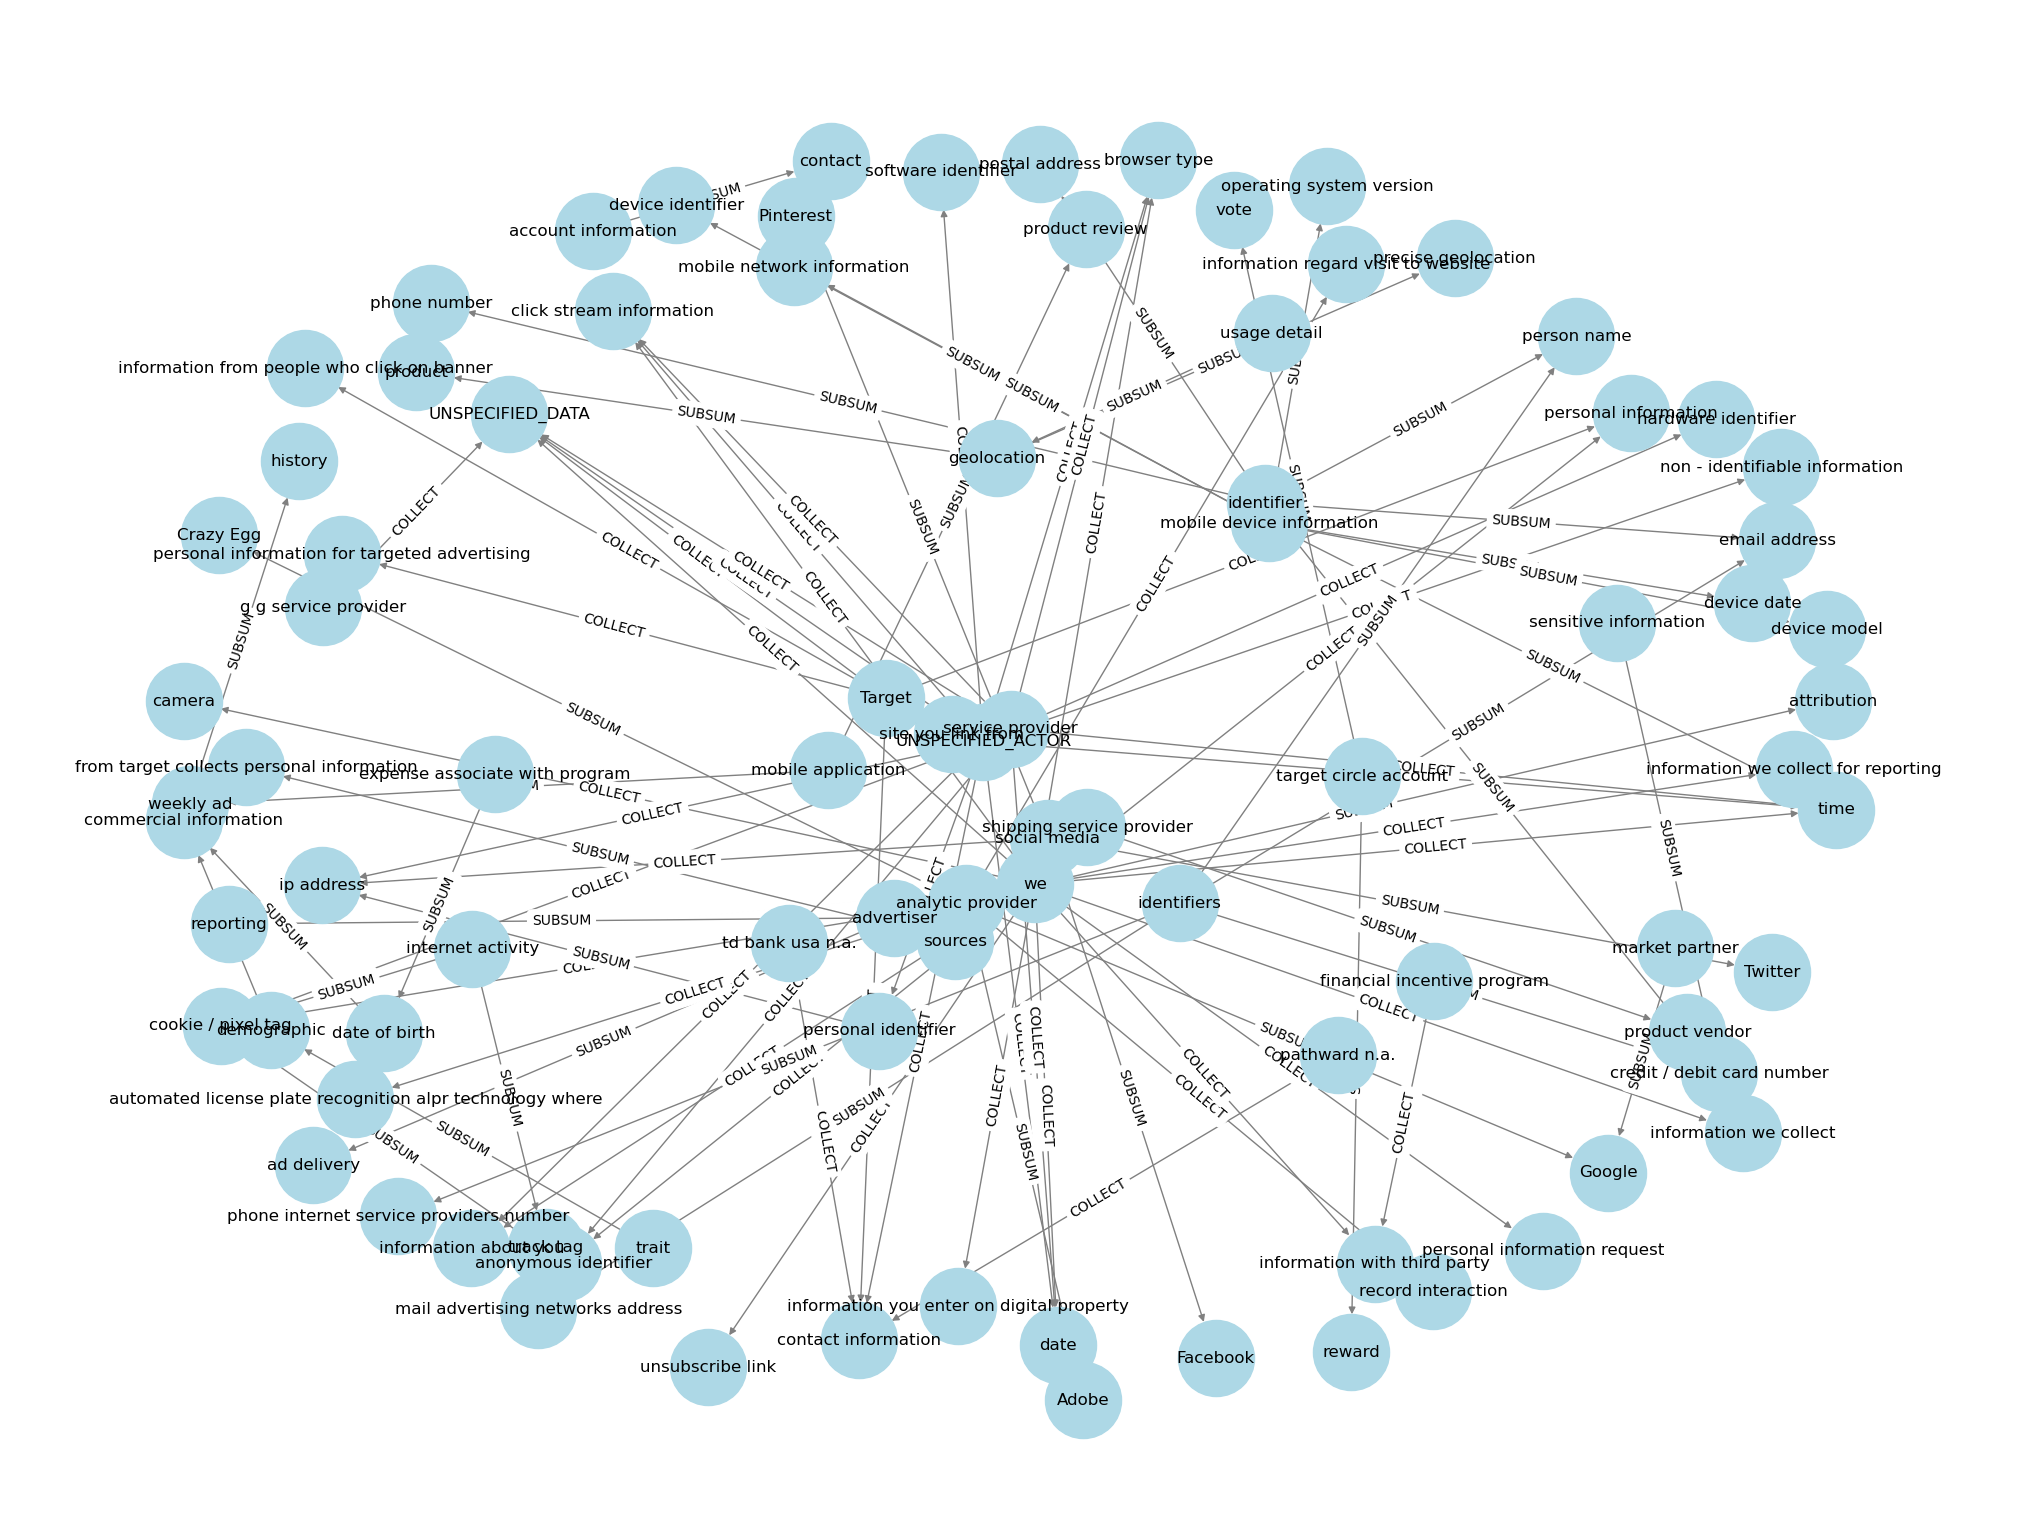

In [12]:
os.chdir("./output")


def needs_graphml_visual(folder):
    pattern = os.path.join(folder, "*" + ".yml")
    has_graphml = len(glob.glob(pattern)) > 0
    if has_graphml:
        return not os.path.exists(f"{folder}/knowledge_graph.png")
    return False


# loop through the output folder and get the graph files
graph_files = []
for root, dirs, files in os.walk("."):
    for dir in dirs:
        full_dir_path = os.path.join(root, dir)
        if needs_graphml_visual(full_dir_path):
            yml_file = os.path.join(full_dir_path, "graph-original.full.yml")
            if os.path.exists(yml_file):
                graph_files.append(yml_file)

for graph_file in graph_files:
    parent_folder = os.path.dirname(graph_file)
    output_png = os.path.join(parent_folder, "knowledge_graph.png")
    print(f"Converting {graph_file} to PNG")

    with open(graph_file, "r") as file:
        data = yaml.safe_load(file)

    G = nx.DiGraph()
    # nodes
    for node in data.get("nodes", []):
        G.add_node(node["id"], type=node["type"])
    # edges
    for link in data.get("links", []):
        G.add_edge(link["source"], link["target"], label=link["key"])

    plt.figure(figsize=(20, 15), facecolor="white")
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        edge_color="gray",
    )
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Knowledge Graph - " + parent_folder)
    plt.savefig(output_png, facecolor="white")

### Table of Relations

In [13]:
def needs_csv_extract(folder):
    pattern = os.path.join(folder, "*" + ".yml")
    has_graphml = len(glob.glob(pattern)) > 0
    if has_graphml:
        return not os.path.exists(f"{folder}/complete_extracted_data.csv")
    return False


# load yml file
def load_yml(file_path):
    if os.path.exists(file_path):
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                return yaml.safe_load(file)
        except Exception as e:
            print(f"Error loading YAML: {e}")
    else:
        print(f"File not found: {file_path}")
    return None


# get relationships from yml file
def extract_yml_relationships(yaml_data):
    relationships = []
    if yml_data and "links" in yml_data:
        for link in yml_data["links"]:
            source = link.get("source", "Unknown Source")
            target = link.get("target", "Unknown Target")
            relation = link.get("key", "Unknown Relationship")
            # combine policy excerpts(references)
            text = " | ".join(link.get("text", []))
            purposes = (
                " | ".join(
                    [
                        f"{k}: {', '.join(v)}"
                        for k, v in link.get("purposes", {}).items()
                    ]
                )
                if link.get("purposes")
                else "None"
            )
            relationships.append((source, relation, target, text, purposes))
    return relationships


# get file paths
yml_path = "graph-original.full.yml"

# loop through the output folder and get the graph files
graph_files = []
for root, dirs, files in os.walk("."):
    for dir in dirs:
        full_dir_path = os.path.join(root, dir)
        if needs_csv_extract(full_dir_path):
            yml_file = os.path.join(full_dir_path, yml_path)
            if os.path.exists(yml_file):
                graph_files.append(yml_file)

for graph_file in graph_files:
    print(f"\nExtracting relationships from '{graph_file}'")
    parent_folder = os.path.dirname(graph_file)
    output_csv_path = os.path.join(parent_folder, "complete_extracted_data.csv")
    # call the funtions
    yml_data = load_yml(graph_file)

    # get relationships from both files
    yml_relationships = extract_yml_relationships(yml_data) if yml_data else []

    # combine results to a DF
    df_combined = pd.DataFrame(
        yml_relationships,
        columns=["Entity", "Relation", "Target Entity", "Policy Text", "Purposes"],
    )

    # save the csv
    df_combined.to_csv(output_csv_path, index=False)
    print(f"\nSaved extracted data to '{output_csv_path}'")


Extracting relationships from './Target_PDF/graph-original.full.yml'

Saved extracted data to './Target_PDF/complete_extracted_data.csv'


In [14]:
# reset current directory location to where the script started
os.chdir("../notebooks")